## Continuous Montain Car environment
### Some notes beforehand
* Continuous Mountain Car is an episodic task with continuous control.
* Orignially implemented a 3-layer feed forward neural network in Tensorflow with relu activation function. Actions are sampled from a paramterized gaussian distribution, whose mean and log-variance are learned by seperate neural nets. Value function is also parameterized by a neural network.
* In experiments, however, only a 1 layer MDP is actually used for solving the mountain car task. From empirical observations, excessive layers and non-linearity is unstable and may diverge to infinity. Eligibility trace is integrated into the network.
* The algorithm employed in this assignment is almost exactly identical to that in Sutton's textbook, except for the $\quad I\leftarrow \gamma I \quad$ used in trace update. There are some other 'minor' changes: 
  1. adding an entropy loss in addition to the $-ln\pi (A|S,\theta)$ when training the actor.
  2. the use of scaler and featurizer to normalize and enrich the original observation.
  3. clipping sampled action value with the range of action_space limits.

In [3]:
! pip install gym
! pip install matplotlib
! pip install scikit-learn

In [0]:
import tensorflow as tf
import numpy as np
import gym
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler
import matplotlib.pyplot as plt


class Policy:

    def __init__(self, obs_dim, act_dim, action_space, discount=0.99, lamb=0.8):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.action_space = action_space
        self.discount = discount
        self.lamb = lamb
        self.epochs = 20  # unused when eligibility trace is active
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn_mu()
            self._policy_nn_sigma()
            self._log_prob()
            self._sample()
            self._trace_init()
            self._loss()
            self._trace()
            self._train()
            self.init = tf.global_variables_initializer()

    def _placeholders(self):
        '''
        Add placeholders to the graph
        :return:
        '''
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.advantages_ph = tf.placeholder(tf.float32, (1,), 'advantage')  # number of time steps, usually
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')

    def _policy_nn_mu(self):
        units = self.obs_dim * 10
        # out = tf.layers.dense(self.obs_ph, units,
        #                       kernel_initializer=tf.random_normal_initializer(
        #                           stddev=np.sqrt(1 / self.obs_dim)),
        #                       name = 'dense_mu_1')
        # out = tf.layers.dense(out, units,
        #                       kernel_initializer=tf.random_normal_initializer(
        #                           stddev=np.sqrt(1 / units)),name='dense_mu_2')
        out = tf.layers.dense(self.obs_ph, self.act_dim,
                              kernel_initializer=tf.random_normal_initializer(
                                  stddev=np.sqrt(1 / self.obs_dim)),
                              name='output_mu')
        self.means = out # tf.Print(out, [out], message='Mean: ', summarize=100)

    def _policy_nn_sigma(self):
        units = self.obs_dim * 10
        # out = tf.layers.dense(self.obs_ph, units,
        #                       kernel_initializer=tf.random_normal_initializer(
        #                           stddev=np.sqrt(1 / self.obs_dim)),
        #                       name='dense_sigma_1')
        # out = tf.layers.dense(out, units,
        #                       kernel_initializer=tf.random_normal_initializer(
        #                           stddev=np.sqrt(1 / units)), name='dense_sigma_2')
        out = tf.layers.dense(self.obs_ph, self.act_dim,
                              kernel_initializer=tf.random_normal_initializer(
                                  stddev=np.sqrt(1 / self.obs_dim)),
                              name='output_sigma')
        # assuming a diagonal covariance for the multi-variate gaussian distributionlogvar_speed = (10 * hid3_size) // 48
        self.log_vars = out

        # self.log_vars = tf.get_variable('variance', (self.act_dim), tf.float32)
        # self.log_vars = tf.Print(self.log_vars, [self.log_vars], message='log var: ')

    def _log_prob(self):
        # add time dim to log_var?
        self.logp = -0.5 * (tf.reduce_sum(self.log_vars) + self.act_dim*tf.log(2*np.pi))  # probability of a trajectory
        self.logp += -0.5 * tf.reduce_sum(tf.square(self.act_ph - self.means) /
                                          tf.exp(self.log_vars), axis=1)

    def _sample(self):
        self.sample = self.means + tf.exp(self.log_vars / 2.0) * \
                       tf.random_normal(shape=(self.act_dim,))
        self.sample = tf.clip_by_value(self.sample, self.action_space.low[0], self.action_space.high[0])
        # self.sample = tf.reshape(self.sample,(self.act_dim,))

    def _trace_init(self):
        """
        Initialize the trace vector; same structure with the gradients
        :return:
        """
        tvs = tf.trainable_variables()
        self.trace = [(tf.Variable(tf.zeros_like(tv), trainable=False)) for tv in tvs]
        self.identity = tf.Variable(1.0, trainable = False, name='identity')
        # reset ops
        self.trace_zero = [self.trace[i].assign(tf.zeros_like(tv)) for i, tv in enumerate(tvs)]
        self.identity_init = [self.identity.assign(1.0)]

    def _loss(self):
        self.loss = -self.logp
        self.loss -= 0.5 * (self.act_dim * (np.log(2 * np.pi) + 1) +
                              tf.reduce_sum(self.log_vars))
        # self.loss -= 1e-1 * self.normal_dist.entropy()

    def _trace(self):
        self.optimizer = tf.train.AdamOptimizer(1e-2)
        self.grads = self.optimizer.compute_gradients(self.loss, tf.trainable_variables())
        self.identity_update = [self.identity.assign(self.identity*self.discount)]
        # self.identity = tf.Print(self.identity, [self.identity], message ='identity: ')
        self.trace_update = [self.trace[i].assign(self.discount * self.lamb * self.trace[i] + self.identity * grad[0]) for i, grad in
                             enumerate(self.grads)]

    def _train(self):
        self.train = self.optimizer.apply_gradients(
            [(self.trace[i] *self.advantages_ph, grad[1]) for i, grad in enumerate(self.grads)])
        # self.train = self.optimizer.apply_gradients(self.trace*self.advantages_ph)
        # self.loss = -self.advantages_ph*self.trace
        # optimizer = tf.train.AdamOptimizer(0.01)
        # self.train = optimizer.minimize(self.loss)

    def _init_session(self):
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def get_sample(self, obs):
        feed_dict = {self.obs_ph: obs}
        return self.sess.run(self.sample, feed_dict=feed_dict)

    def update(self, observes, actions, advantages):
        feed_dict = {self.obs_ph: observes,
                     self.act_ph: actions,
                     self.advantages_ph: advantages
                     }
        self.sess.run(self.trace_update, feed_dict)
        # self.sess.run(self.identity_update)
        self.sess.run([self.train,self.loss], feed_dict)

    def close_sess(self):
        self.sess.close()


class ValueFunc:
    def __init__(self, obs_dim, discount=0.99, lamb=0.8):
        self.obs_dim = obs_dim
        self.epochs = 10
        self.discount = discount
        self.lamb = lamb
        self._build_graph()
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs_ph')
            self.advantages_ph = tf.placeholder(tf.float32, (None,), 'advantages_ph')

            units = self.obs_dim * 10
            # out = tf.layers.dense(self.obs_ph, units, tf.nn.relu,
            #                       kernel_initializer=tf.random_normal_initializer(
            #                         stddev=np.sqrt(1 / self.obs_dim)),
            #                       name="valfunc_d1")
            # out = tf.layers.dense(out, units,
            #                       kernel_initializer=tf.random_normal_initializer(
            #                           stddev=np.sqrt(1 / units)),
            #                       name="valfunc_d2")
            out = tf.layers.dense(self.obs_ph, 1,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=np.sqrt(1 / self.obs_dim)),
                                  name='output')
            # out = tf.Print(out, [out], message='out: ')
            self.out = tf.squeeze(out)  # remove dimensions of size 1 from the shape
            # self.out = tf.Print(out, [out], message='value prediction: ')
            # gradient ascent
            self.loss = -self.out
            # initialize trace
            tvs = tf.trainable_variables()
            self.trace = [(tf.Variable(tf.zeros_like(tv), trainable=False)) for tv in tvs]
            self.identity = tf.Variable(1.0, trainable=False, name='identity')
            # reset ops
            self.trace_zero = [self.trace[i].assign(tf.zeros_like(tv)) for i, tv in enumerate(tvs)]
            self.identity_init = [self.identity.assign(1.0)]

            self.optimizer = tf.train.AdamOptimizer(1e-2)
            self.grads = self.optimizer.compute_gradients(self.loss, tf.trainable_variables())
            self.identity_update = [self.identity.assign(self.identity*self.discount)]
            self.trace_update = [self.trace[i].assign(self.discount * self.lamb * self.trace[i] + grad[0]) for i, grad
                                 in enumerate(self.grads)]

            self.train = self.optimizer.apply_gradients(
                [(self.trace[i] * self.advantages_ph, grad[1]) for i, grad in enumerate(self.grads)])
            self.init = tf.global_variables_initializer()
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def update(self, observes, advantages):
        feed_dict = {self.obs_ph: observes,
                     self.advantages_ph: advantages
                     }

        self.sess.run(self.trace_update, feed_dict)
        # self.sess.run(self.identity_update)
        self.sess.run([self.train, self.loss], feed_dict)

    def predict(self, obs):
        feed_dict = {self.obs_ph: obs}
        val = self.sess.run(self.out, feed_dict=feed_dict)
        return np.squeeze(val)

    def close_sess(self):
        self.sess.close()

class Experiment:

    def __init__(self, env_name, discount=0.99):
        self.env = gym.make(env_name)
        self.obs_dim = 400 #self.env.observation_space.shape[0]
        self.act_dim = self.env.action_space.shape[0]
        self.discount = discount
        self.policy = Policy(self.obs_dim, self.act_dim, self.env.action_space)
        self.value_func = ValueFunc(self.obs_dim)

        print('observation dimension:', self.obs_dim)
        print('action dimension:', self.act_dim)

        # featurizer!
        observation_examples = np.array([self.env.observation_space.sample() for x in range(10000)])
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(observation_examples)

        self.featurizer = sklearn.pipeline.FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
        self.featurizer.fit(self.scaler.transform(observation_examples))

    def featurize_obs(self, obs):
        """
           Returns the featurized representation for a state.
        """
        scaled = None
        try:
            scaled = self.scaler.transform([obs])
        except ValueError:
            pass
        featurized = self.featurizer.transform(scaled)
        return featurized[0]

    def run_one_epsisode(self):
        obs = self.env.reset()
        obs = self.featurize_obs(obs)
        obs = obs.astype(np.float64).reshape((1, -1))
        observes, actions, rewards = [], [], []
        done = False
        step = 0
        while not done:
            # self.env.render()
            # observes.append(obs)

            # print('samping')
            action = self.policy.get_sample(obs).reshape((1, -1)).astype(np.float64)
            # print('action', action)
            # actions.append(action)

            obs_new, reward, done, _ = self.env.step(action)
            obs_new = obs_new.astype(np.float64).reshape((-1,))  # major mistake solved here
            obs_new = self.featurize_obs(obs_new)
            obs_new = obs_new.astype(np.float64).reshape((1, -1))

            if not isinstance(reward, float):
                reward = np.asscalar(reward)
            rewards.append(reward)

            # print('computing advantage')
            advantage = reward + self.discount * self.value_func.predict(obs_new) - self.value_func.predict(obs)
            advantage = advantage.astype(np.float64).reshape((1,))

            # print('advantage', advantage)

            # print('policy update')
            self.policy.update(obs, action, advantage)
            # print('value function update')
            self.value_func.update(obs, advantage)

            obs = obs_new
            step += 0.001

        return observes, actions, rewards

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation dimension: 400
action dimension: 1
episode:  0
total steps: 999, episode_reward: -74.70324408958805
episode:  1
total steps: 115, episode_reward: 90.05853125653711
episode:  2
total steps: 243, episode_reward: 79.73233043171363
episode:  3
total steps: 202, episode_reward: 82.05336153525876
episode:  4
total steps: 206, episode_reward: 82.772700134434
episode:  5
total steps: 203, episode_reward: 81.8840236571281
episode:  6
total steps: 280, episode_reward: 76.43390577876423
episode:  7
total steps: 288, episode_reward: 76.45012234973045
episode:  8
total steps: 191, episode_reward: 84.42779625545703
episode:  9
total steps: 383, episode_reward: 67.77841529068748
episode:  10
total steps: 311, episode_reward: 73.60116545393895
episode:  11
total steps: 284, episode_reward: 76.14

total steps: 198, episode_reward: 84.79749521237495
episode:  51
total steps: 312, episode_reward: 73.41821832697923
episode:  52
total steps: 165, episode_reward: 86.88670161953995
episode:  53
total steps: 265, episode_reward: 77.99172808006024
episode:  54
total steps: 304, episode_reward: 75.34037708478942
episode:  55
total steps: 211, episode_reward: 81.92285931486356
episode:  56
total steps: 353, episode_reward: 71.77209934603721
episode:  57
total steps: 209, episode_reward: 83.18513539619288
episode:  58
total steps: 306, episode_reward: 74.51828430729628
episode:  59
total steps: 189, episode_reward: 85.21763605774034
episode:  60
total steps: 339, episode_reward: 71.2874701731774
episode:  61
total steps: 392, episode_reward: 67.92047394183435
episode:  62
total steps: 279, episode_reward: 77.12843950192934
episode:  63
total steps: 222, episode_reward: 81.24138723150037
episode:  64
total steps: 305, episode_reward: 74.6455231003774
episode:  65
total steps: 196, episode_r

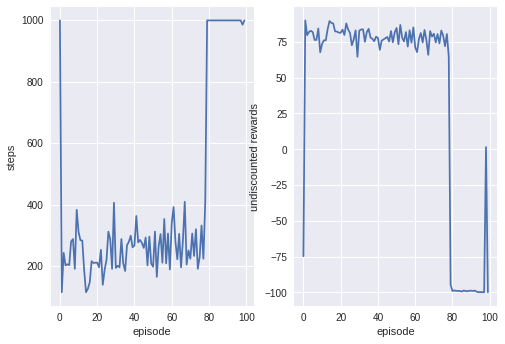

In [5]:
# network too big will explode!!
env = Experiment('MountainCarContinuous-v0')
steps = []
undiscounted = []
# 100 episodes
for i in range(100):
    # trace vectors are emptied at the beginning of each episode
    env.policy.sess.run(env.policy.trace_zero)
    env.policy.sess.run(env.policy.identity_init)
    env.value_func.sess.run(env.value_func.trace_zero)
    env.value_func.sess.run(env.value_func.identity_init)

    print('episode: ', i)
    _, _, rewards = env.run_one_epsisode()
    total_steps = len(rewards)
    print('total steps: {0}, episode_reward: {1}'.format(total_steps, np.sum(rewards)))
    steps.append(total_steps)
    undiscounted.append(np.sum(rewards))

plt.subplot(121)
plt.xlabel('episode')
plt.ylabel('steps')
plt.plot(steps)

plt.subplot(122)
plt.xlabel('episode')
plt.ylabel('undiscounted rewards')
plt.plot(undiscounted)

* Requirement for solving this task is to have a reward over 90.0 in at least 100 consecutive episodes.
* Initialization of the policy is vital to the success of this task. It may happen that the agent get stuck at the bottom in the beginning, therefore having trouble to explore further.

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation dimension: 400
action dimension: 1
episode:  0
total steps: 324, episode_reward: 75.30661268142818
episode:  1
total steps: 133, episode_reward: 90.96028170648164
episode:  2
total steps: 328, episode_reward: 78.02838543143618
episode:  3
total steps: 999, episode_reward: -72.95185802146761
episode:  4
total steps: 999, episode_reward: -98.4637157851412
episode:  5
total steps: 999, episode_reward: -98.57531995000754
episode:  6
total steps: 999, episode_reward: -97.3525267907591
episode:  7
total steps: 999, episode_reward: -98.40880658203235
episode:  8
total steps: 999, episode_reward: -96.96115141893785
episode:  9
total steps: 999, episode_reward: -98.15037590883617
episode:  10
total steps: 999, episode_reward: -97.56629157581783
episode:  11
total steps: 999, episode_rewar

total steps: 999, episode_reward: -99.64590016144585
episode:  53
total steps: 999, episode_reward: -99.79601566525017
episode:  54
total steps: 999, episode_reward: -99.79929922067615
episode:  55
total steps: 999, episode_reward: -99.8261507753713
episode:  56
total steps: 999, episode_reward: -99.72854067101262
episode:  57
total steps: 999, episode_reward: -99.9
episode:  58
total steps: 999, episode_reward: -99.9
episode:  59
total steps: 999, episode_reward: -99.9
episode:  60
total steps: 999, episode_reward: -99.9
episode:  61
total steps: 999, episode_reward: -99.9
episode:  62
total steps: 999, episode_reward: -99.9
episode:  63
total steps: 999, episode_reward: -99.9
episode:  64
total steps: 999, episode_reward: -99.9
episode:  65
total steps: 999, episode_reward: -99.9
episode:  66
total steps: 999, episode_reward: -99.9
episode:  67
total steps: 999, episode_reward: -99.9
episode:  68
total steps: 999, episode_reward: -99.9
episode:  69
total steps: 999, episode_reward: -

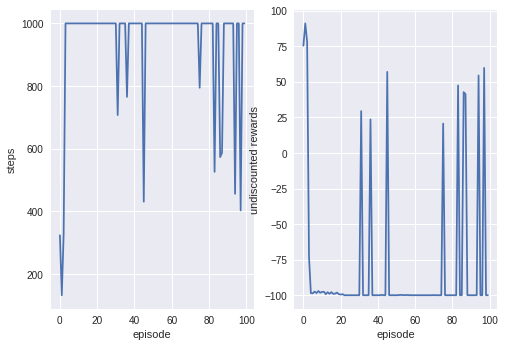

In [6]:
env = Experiment('MountainCarContinuous-v0')
steps = []
undiscounted = []
# 100 episodes
for i in range(100):
    # trace vectors are emptied at the beginning of each episode
    env.policy.sess.run(env.policy.trace_zero)
    env.policy.sess.run(env.policy.identity_init)
    env.value_func.sess.run(env.value_func.trace_zero)
    env.value_func.sess.run(env.value_func.identity_init)

    print('episode: ', i)
    _, _, rewards = env.run_one_epsisode()
    total_steps = len(rewards)
    print('total steps: {0}, episode_reward: {1}'.format(total_steps, np.sum(rewards)))
    steps.append(total_steps)
    undiscounted.append(np.sum(rewards))

plt.subplot(121)
plt.xlabel('episode')
plt.ylabel('steps')
plt.plot(steps)

plt.subplot(122)
plt.xlabel('episode')
plt.ylabel('undiscounted rewards')
plt.plot(undiscounted)

This picture shows that the agent may have trouble learning the policy.

## two-layers FNN with relu activation function

In [0]:
class NonlinearPolicy:
  
    def __init__(self, obs_dim, act_dim, action_space, discount=0.99, lamb=0.8):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.action_space = action_space
        self.discount = discount
        self.lamb = lamb
        self.epochs = 20  # unused when eligibility trace is active
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn_mu()
            self._policy_nn_sigma()
            self._log_prob()
            self._sample()
            self._trace_init()
            self._loss()
            self._trace()
            self._train()
            self.init = tf.global_variables_initializer()

    def _placeholders(self):
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.advantages_ph = tf.placeholder(tf.float32, (1,), 'advantage')  # number of time steps, usually
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')

    def _policy_nn_mu(self):
        units = self.obs_dim * 10
        out = tf.layers.dense(self.obs_ph, units, tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(
                                  stddev=np.sqrt(1 / self.obs_dim)),
                              name = 'dense_mu_1')
        out = tf.layers.dense(out, self.act_dim,
                              kernel_initializer=tf.random_normal_initializer(
                                  stddev=np.sqrt(1 / self.obs_dim)),
                              name='output_mu')
        self.means = out

    def _policy_nn_sigma(self):
        units = self.obs_dim * 10
        out = tf.layers.dense(self.obs_ph, units, tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(
                                  stddev=np.sqrt(1 / self.obs_dim)),
                              name='dense_sigma_1')
        out = tf.layers.dense(out, self.act_dim,
                              kernel_initializer=tf.random_normal_initializer(
                                  stddev=np.sqrt(1 / self.obs_dim)),
                              name='output_sigma')
        
        # assuming a diagonal covariance for the multi-variate gaussian distributionlogvar_speed = (10 * hid3_size) // 48
        self.log_vars = out

    def _log_prob(self):
        self.logp = -0.5 * (tf.reduce_sum(self.log_vars) + self.act_dim*tf.log(2*np.pi))  # probability of a trajectory
        self.logp += -0.5 * tf.reduce_sum(tf.square(self.act_ph - self.means) /
                                          tf.exp(self.log_vars), axis=1)

    def _sample(self):
        self.sample = self.means + tf.exp(self.log_vars / 2.0) * \
                       tf.random_normal(shape=(self.act_dim,))
        self.sample = tf.clip_by_value(self.sample, self.action_space.low[0], self.action_space.high[0])

    def _trace_init(self):
        tvs = tf.trainable_variables()
        self.trace = [(tf.Variable(tf.zeros_like(tv), trainable=False)) for tv in tvs]
        # reset ops
        self.trace_zero = [self.trace[i].assign(tf.zeros_like(tv)) for i, tv in enumerate(tvs)]

    def _loss(self):
        self.loss = -self.logp
        self.loss -= 0.5 * (self.act_dim * (np.log(2 * np.pi) + 1) +
                              tf.reduce_sum(self.log_vars))

    def _trace(self):
        self.optimizer = tf.train.AdamOptimizer(1e-2)
        self.grads = self.optimizer.compute_gradients(self.loss, tf.trainable_variables())
        self.trace_update = [self.trace[i].assign(self.discount * self.lamb * self.trace[i] + grad[0]) for i, grad in
                             enumerate(self.grads)]

    def _train(self):
        self.train = self.optimizer.apply_gradients(
            [(self.trace[i] * self.advantages_ph, grad[1]) for i, grad in enumerate(self.grads)])

    def _init_session(self):
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def get_sample(self, obs):
        feed_dict = {self.obs_ph: obs}
        return self.sess.run(self.sample, feed_dict=feed_dict)

    def update(self, observes, actions, advantages):
        feed_dict = {self.obs_ph: observes,
                     self.act_ph: actions,
                     self.advantages_ph: advantages
                     }
        self.sess.run(self.trace_update, feed_dict)
        self.sess.run([self.train, self.loss], feed_dict)

    def close_sess(self):
        self.sess.close()
        
        
class NonlinearValueFunc:
  
    def __init__(self, obs_dim, discount=0.99, lamb=0.8):
        self.obs_dim = obs_dim
        self.epochs = 10
        self.discount = discount
        self.lamb = lamb
        self._build_graph()
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs_ph')
            self.advantages_ph = tf.placeholder(tf.float32, (None,), 'advantages_ph')

            units = self.obs_dim * 10
            out = tf.layers.dense(self.obs_ph, units, tf.nn.relu,
                                  kernel_initializer=tf.random_normal_initializer(
                                    stddev=np.sqrt(1 / self.obs_dim)),
                                  name="valfunc_d1")
            out = tf.layers.dense(out, 1,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=np.sqrt(1 / self.obs_dim)),
                                  name='output')
            self.out = tf.squeeze(out)
            # gradient ascent
            self.loss = -self.out
            # initialize trace
            tvs = tf.trainable_variables()
            self.trace = [(tf.Variable(tf.zeros_like(tv), trainable=False)) for tv in tvs]
            # reset ops
            self.trace_zero = [self.trace[i].assign(tf.zeros_like(tv)) for i, tv in enumerate(tvs)]

            self.optimizer = tf.train.AdamOptimizer(1e-2)
            self.grads = self.optimizer.compute_gradients(self.loss, tf.trainable_variables())
            self.trace_update = [self.trace[i].assign(self.discount * self.lamb * self.trace[i] + grad[0]) for i, grad
                                 in enumerate(self.grads)]

            self.train = self.optimizer.apply_gradients(
                [(self.trace[i] * self.advantages_ph, grad[1]) for i, grad in enumerate(self.grads)])
            self.init = tf.global_variables_initializer()
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def update(self, observes, advantages):
        feed_dict = {self.obs_ph: observes,
                     self.advantages_ph: advantages
                     }

        self.sess.run(self.trace_update, feed_dict)
        self.sess.run([self.train, self.loss], feed_dict)

    def predict(self, obs):
        feed_dict = {self.obs_ph: obs}
        val = self.sess.run(self.out, feed_dict=feed_dict)
        return np.squeeze(val)

    def close_sess(self):
        self.sess.close()

class NonlinearExperiment:

    def __init__(self, env_name, discount=0.99):
        self.env = gym.make(env_name)
        self.obs_dim = 401 # add time dimension
        self.act_dim = self.env.action_space.shape[0]
        self.discount = discount
        self.policy = NonlinearPolicy(self.obs_dim, self.act_dim, self.env.action_space)
        self.value_func = NonlinearValueFunc(self.obs_dim)

        print('observation dimension:', self.obs_dim)
        print('action dimension:', self.act_dim)

        observation_examples = np.array([self.env.observation_space.sample() for x in range(10000)])
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(observation_examples)

        self.featurizer = sklearn.pipeline.FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
        self.featurizer.fit(self.scaler.transform(observation_examples))

    def featurize_obs(self, obs):
        scaled = None
        try:
            scaled = self.scaler.transform([obs])
        except ValueError:
            pass
        featurized = self.featurizer.transform(scaled)
        return featurized[0]

    def run_one_epsisode(self):
        obs = self.env.reset()
        step = 0
        obs = self.featurize_obs(obs)
        obs = np.append(obs, [step], axis=0)
        obs = obs.astype(np.float64).reshape((1, -1))
        observes, actions, rewards = [], [], []
        done = False
        while not done:
            step += 0.001
            action = self.policy.get_sample(obs).reshape((1, -1)).astype(np.float64)

            obs_new, reward, done, _ = self.env.step(action)
            obs_new = obs_new.astype(np.float64).reshape((-1,))
            obs_new = self.featurize_obs(obs_new)
            obs_new = np.append(obs_new, [step], axis=0)
            obs_new = obs_new.astype(np.float64).reshape((1, -1))

            if not isinstance(reward, float):
                reward = np.asscalar(reward)
            rewards.append(reward)

            advantage = reward + self.discount * self.value_func.predict(obs_new) - self.value_func.predict(obs)
            advantage = advantage.astype(np.float64).reshape((1,))

            self.policy.update(obs, action, advantage)
            self.value_func.update(obs, advantage)

            obs = obs_new
        return observes, actions, rewards

In [18]:
env = NonlinearExperiment('MountainCarContinuous-v0')
steps = []
undiscounted = []
# 100 episodes
for i in range(100):
    # trace vectors are emptied at the beginning of each episode
    env.policy.sess.run(env.policy.trace_zero)
    env.value_func.sess.run(env.value_func.trace_zero)

    print('episode: ', i)
    _, _, rewards = env.run_one_epsisode()
    total_steps = len(rewards)
    print('total steps: {0}, episode_reward: {1}'.format(total_steps, np.sum(rewards)))
    steps.append(total_steps)
    undiscounted.append(np.sum(rewards))

plt.subplot(121)
plt.xlabel('episode')
plt.ylabel('steps')
plt.plot(steps)

plt.subplot(122)
plt.xlabel('episode')
plt.ylabel('undiscounted rewards')
plt.plot(undiscounted)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation dimension: 401
action dimension: 1
episode:  0
total steps: 832, episode_reward: 17.000662449312863
episode:  1
total steps: 834, episode_reward: 16.6
episode:  2
total steps: 999, episode_reward: -99.9
episode:  3
total steps: 999, episode_reward: -99.9
episode:  4
total steps: 439, episode_reward: 56.1
episode:  5
total steps: 999, episode_reward: -99.9
episode:  6
total steps: 999, episode_reward: -99.9
episode:  7
total steps: 999, episode_reward: -99.9
episode:  8
total steps: 999, episode_reward: -99.9
episode:  9
total steps: 741, episode_reward: 25.900000000000013
episode:  10
total steps: 999, episode_reward: -99.9
episode:  11
total steps: 999, episode_reward: -99.9
episode:  12
total steps: 999, episode_reward: -99.9
episode:  13
total steps: 999, episode_reward: -99.9

KeyboardInterrupt: ignored

### Nonlinear method is quite slow. We stop evaluating it, since it isn't prone to yield any conspicuous improvement.

In [0]:
class NonTracePolicy:
  
    def __init__(self, obs_dim, act_dim, action_space, discount=0.99, lamb=0.8):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.action_space = action_space
        self.discount = discount
        self.lamb = lamb
        self.epochs = 20  # unused when eligibility trace is active
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn_mu()
            self._policy_nn_sigma()
            self._log_prob()
            self._sample()
            self._loss()
            self._train()
            self.init = tf.global_variables_initializer()

    def _placeholders(self):
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.advantages_ph = tf.placeholder(tf.float32, (1,), 'advantage')  # number of time steps, usually
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')

    def _policy_nn_mu(self):
        out = tf.layers.dense(self.obs_ph, self.act_dim,
                              kernel_initializer=tf.random_normal_initializer(
                                  stddev=np.sqrt(1 / self.obs_dim)),
                              name='output_mu')
        self.means = out

    def _policy_nn_sigma(self):
        out = tf.layers.dense(self.obs_ph, self.act_dim,
                              kernel_initializer=tf.random_normal_initializer(
                                  stddev=np.sqrt(1 / self.obs_dim)),
                              name='output_sigma')
        
        # assuming a diagonal covariance for the multi-variate gaussian distributionlogvar_speed = (10 * hid3_size) // 48
        self.log_vars = out

    def _log_prob(self):
        self.logp = -0.5 * (tf.reduce_sum(self.log_vars) + self.act_dim*tf.log(2*np.pi))  # probability of a trajectory
        self.logp += -0.5 * tf.reduce_sum(tf.square(self.act_ph - self.means) /
                                          tf.exp(self.log_vars), axis=1)

    def _sample(self):
        self.sample = self.means + tf.exp(self.log_vars / 2.0) * \
                       tf.random_normal(shape=(self.act_dim,))
        self.sample = tf.clip_by_value(self.sample, self.action_space.low[0], self.action_space.high[0])


    def _loss(self):
        self.loss = -self.logp
        self.loss -= 0.5 * (self.act_dim * (np.log(2 * np.pi) + 1) +
                              tf.reduce_sum(self.log_vars))
        self.loss *= self.advantages_ph

    def _train(self):
        # fixed learning rate: we can do better than that by being adaptive 
        self.optimizer = tf.train.AdamOptimizer(1e-5)
        self.train = self.optimizer.minimize(self.loss)

    def _init_session(self):
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def get_sample(self, obs):
        feed_dict = {self.obs_ph: obs}
        return self.sess.run(self.sample, feed_dict=feed_dict)

    def update(self, observes, actions, advantages):
        feed_dict = {self.obs_ph: observes,
                     self.act_ph: actions,
                     self.advantages_ph: advantages
                     }
        self.sess.run([self.train, self.loss], feed_dict)

    def close_sess(self):
        self.sess.close()
        
        
class NonTraceValueFunc:
  
    def __init__(self, obs_dim, discount=0.99, lamb=0.8):
        self.obs_dim = obs_dim
        self.epochs = 10
        self.discount = discount
        self.lamb = lamb
        self._build_graph()
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs_ph')
            self.advantages_ph = tf.placeholder(tf.float32, (None,), 'advantages_ph')

            units = self.obs_dim * 10
            out = tf.layers.dense(self.obs_ph, 1,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=np.sqrt(1 / self.obs_dim)),
                                  name='output')
            self.out = tf.squeeze(out)
            # gradient ascent
            self.loss = -self.out*self.advantages_ph

            self.optimizer = tf.train.AdamOptimizer(1e-2)
            self.train = self.optimizer.minimize(self.loss)
            
            self.init = tf.global_variables_initializer()
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def update(self, observes, advantages):
        feed_dict = {self.obs_ph: observes,
                     self.advantages_ph: advantages
                     }
        
        self.sess.run([self.train, self.loss], feed_dict)

    def predict(self, obs):
        feed_dict = {self.obs_ph: obs}
        val = self.sess.run(self.out, feed_dict=feed_dict)
        return np.squeeze(val)

    def close_sess(self):
        self.sess.close()

class VariantExperiment:

    def __init__(self, env_name, policy, value_func, discount=0.99):
        self.env = gym.make(env_name)
        self.obs_dim = 400
        self.act_dim = self.env.action_space.shape[0]
        self.discount = discount
        self.policy = policy
        self.value_func = value_func

        print('observation dimension:', self.obs_dim)
        print('action dimension:', self.act_dim)

        observation_examples = np.array([self.env.observation_space.sample() for x in range(10000)])
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(observation_examples)

        self.featurizer = sklearn.pipeline.FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
        self.featurizer.fit(self.scaler.transform(observation_examples))

    def featurize_obs(self, obs):
        scaled = None
        featurized = None
        try:
            scaled = self.scaler.transform([obs])
            featurized = self.featurizer.transform(scaled)
        except ValueError:
            print(obs)
            print(scaled)
        return featurized[0]

    def run_one_epsisode(self):
        obs = self.env.reset()
        obs = self.featurize_obs(obs)
        obs = obs.astype(np.float64).reshape((1, -1))
        rewards = []
        done = False
        while not done:
            action = self.policy.get_sample(obs).reshape((1, -1)).astype(np.float64)

            obs_new, reward, done, _ = self.env.step(action)
            obs_new = obs_new.astype(np.float64).reshape((-1,))
            obs_new = self.featurize_obs(obs_new)
            obs_new = obs_new.astype(np.float64).reshape((1, -1))

            if not isinstance(reward, float):
                reward = np.asscalar(reward)
            rewards.append(reward)

            advantage = reward + self.discount * self.value_func.predict(obs_new) - self.value_func.predict(obs)
            advantage = advantage.astype(np.float64).reshape((1,))

            self.policy.update(obs, action, advantage)
            self.value_func.update(obs, advantage)

            obs = obs_new
        return rewards

## Test run these variants

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation dimension: 400
action dimension: 1
episode:  0
total steps: 999, episode_reward: -52.20300974429563
episode:  1
total steps: 999, episode_reward: -53.344955050991395
episode:  2
total steps: 999, episode_reward: -49.69099429220224
episode:  3
total steps: 999, episode_reward: -51.942204751997195
episode:  4
total steps: 999, episode_reward: -49.96897504184646
episode:  5
total steps: 820, episode_reward: 57.236049021811574
episode:  6
total steps: 999, episode_reward: -48.802173390403375
episode:  7
total steps: 999, episode_reward: -50.8392344162196
episode:  8
total steps: 999, episode_reward: -48.3421455043766
episode:  9
total steps: 999, episode_reward: -50.513114341724744
epis

total steps: 408, episode_reward: 82.46361393400883
episode:  50
total steps: 442, episode_reward: 78.95265223098347
episode:  51
total steps: 556, episode_reward: 77.20728587802327
episode:  52
total steps: 645, episode_reward: 73.23334984363285
episode:  53
total steps: 325, episode_reward: 85.22609107576251
episode:  54
total steps: 446, episode_reward: 78.31234692953917
episode:  55
total steps: 343, episode_reward: 84.72075323517218
episode:  56
total steps: 490, episode_reward: 77.26339926348152
episode:  57
total steps: 291, episode_reward: 86.68288657903852
episode:  58
total steps: 507, episode_reward: 78.30386826824585
episode:  59
total steps: 342, episode_reward: 84.41359877557453
episode:  60
total steps: 405, episode_reward: 82.87108321774468
episode:  61
total steps: 282, episode_reward: 86.62291728124679
episode:  62
total steps: 417, episode_reward: 80.2850052267452
episode:  63
total steps: 377, episode_reward: 84.08232037177643
episode:  64
total steps: 347, episode_

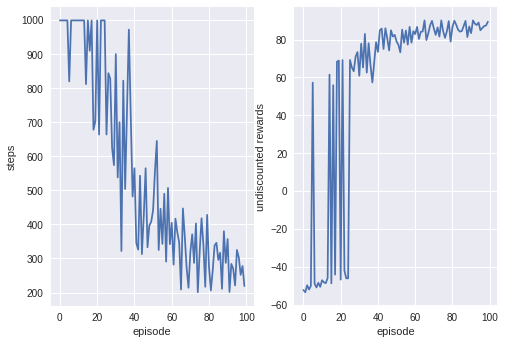

In [30]:
env = VariantExperiment('MountainCarContinuous-v0', 
                        NonTracePolicy(400, 1, gym.spaces.Box(low=-1.0, high=1.0, shape=(1,))), 
                        ValueFunc(400))
steps = []
undiscounted = []
# 100 episodes
for i in range(100):
    env.value_func.sess.run(env.value_func.trace_zero)
    print('episode: ', i)
    rewards = env.run_one_epsisode()
    total_steps = len(rewards)
    print('total steps: {0}, episode_reward: {1}'.format(total_steps, np.sum(rewards)))
    steps.append(total_steps)
    undiscounted.append(np.sum(rewards))

plt.subplot(121)
plt.xlabel('episode')
plt.ylabel('steps')
plt.plot(steps)

plt.subplot(122)
plt.xlabel('episode')
plt.ylabel('undiscounted rewards')
plt.plot(undiscounted)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation dimension: 400
action dimension: 1
episode:  0
total steps: 999, episode_reward: -52.0591670712205
episode:  1
total steps: 999, episode_reward: -50.81634728051201
episode:  2
total steps: 999, episode_reward: -52.16129348470801
episode:  3
total steps: 999, episode_reward: -52.896223883809334
episode:  4
total steps: 999, episode_reward: -49.7139663173142
episode:  5
total steps: 999, episode_reward: -51.306191227297006
episode:  6
total steps: 999, episode_reward: -48.743874193354415
episode:  7
total steps: 999, episode_reward: -50.64367340380714
episode:  8
total steps: 999, episode_reward: -49.64591071094743
episode:  9
total steps: 999, episode_reward: -51.09772791530649
episo

total steps: 218, episode_reward: 87.84690221393025
episode:  50
total steps: 517, episode_reward: 74.3933420819349
episode:  51
total steps: 310, episode_reward: 84.26533317723062
episode:  52
total steps: 407, episode_reward: 78.77634314833413
episode:  53
total steps: 336, episode_reward: 83.71953112075632
episode:  54
total steps: 413, episode_reward: 79.3738534591655
episode:  55
total steps: 378, episode_reward: 81.10642539584953
episode:  56
total steps: 441, episode_reward: 78.67053740969779
episode:  57
total steps: 353, episode_reward: 81.48763024179931
episode:  58
total steps: 410, episode_reward: 78.53534894050816
episode:  59
total steps: 365, episode_reward: 82.09559871570991
episode:  60
total steps: 494, episode_reward: 74.1176529588677
episode:  61
total steps: 430, episode_reward: 78.54781806597965
episode:  62
total steps: 240, episode_reward: 87.79734207275791
episode:  63
total steps: 381, episode_reward: 81.24863906345651
episode:  64
total steps: 206, episode_re

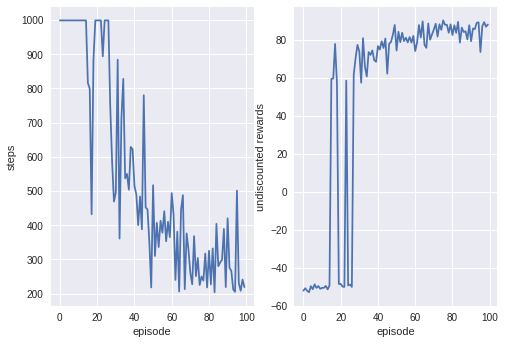

In [32]:
env = VariantExperiment('MountainCarContinuous-v0', 
                        NonTracePolicy(400, 1, gym.spaces.Box(low=-1.0, high=1.0, shape=(1,))), 
                        NonTraceValueFunc(400))
steps = []
undiscounted = []
# 100 episodes
for i in range(100):
    print('episode: ', i)
    rewards = env.run_one_epsisode()
    total_steps = len(rewards)
    print('total steps: {0}, episode_reward: {1}'.format(total_steps, np.sum(rewards)))
    steps.append(total_steps)
    undiscounted.append(np.sum(rewards))

plt.subplot(121)
plt.xlabel('episode')
plt.ylabel('steps')
plt.plot(steps)

plt.subplot(122)
plt.xlabel('episode')
plt.ylabel('undiscounted rewards')
plt.plot(undiscounted)

These two variants have achieved pretty good performance.